# Reduced fragment library: Original ligands coverage

## Aim of this notebook

We want to know (i) which original ligands can be fully recombined by the reduced fragment library and (ii) how many original ligands are represented by at least one fragment. This will help us to check our combinatorial library for expected results later.

## Table of contents

1. Load full fragment library
2. Load reduced fragment library
3. Load original ligands
4. How many ligands are (fully) covered by the reduced library?

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

from utils import read_fragment_library, draw_ligands_from_pdb_ids

In [2]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [3]:
# Path to data
PATH_DATA = Path('.') / '..' / 'data'

## 1. Load full fragment library

In [4]:
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

## 2. Load reduced fragment library

Number of fragments in reduced library: 624


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AKT2,Akt,AGC,3e87,G95,B,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP FP,16 16 16 16 16 16 16 16 16 16 16 16 16 16 na,c1cnc2[nH]ccc2c1,*c1ccnc2[nH]ccc12,AP
1,,,,AKT1,Akt,AGC,3ocb,XM1,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP FP,14 14 14 14 14 14 14 14 14 14 14 14 14 na,c1ncc2cc[nH]c2n1,*c1ncnc2[nH]ccc12,AP

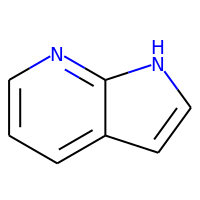
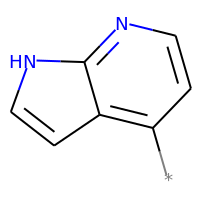
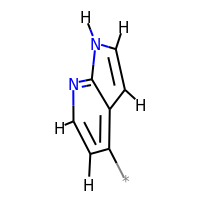
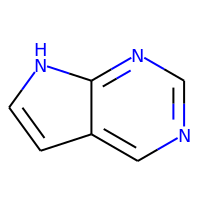
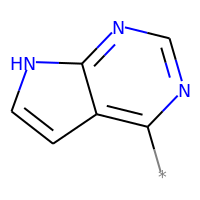
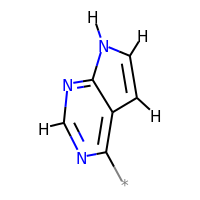

In [5]:
fragment_library_reduced = read_fragment_library(PATH_DATA / 'fragment_library_reduced')
fragment_library_concat_reduced = pd.concat(fragment_library_reduced).reset_index(drop=True)
print(f'Number of fragments in reduced library: {fragment_library_concat_reduced.shape[0]}')
fragment_library_concat_reduced.head(2)

## 3. Load original ligands

In [6]:
original_ligands = pd.read_json(PATH_DATA / 'fragment_library' / 'original_ligands.json')
print(f'Number of original ligands: {original_ligands.shape[0]}')
original_ligands.head(2)

Number of original ligands: 2553


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...


## 4. How many ligands are (fully) covered by the reduced library?

Loop over each subpocket pool in the full library and ask for each fragment if it is part of the respective reduced library's subpocket pool.

In [7]:
def _add_in_reduced_library_column(fragment_library, fragment_library_concat_reduced):
    """
    Take fragment library and add per subpocket pool an additional column stating if each fragment is part of the reduced fragment library.
    Fragments in the full library are considered to be part of the reduced library if
    - they match a SMILES in the reduced library (in the same subpocket),
    - they match in atom enviroments, i.e. atoms have the same BRICS rules, (in the same subpocket), and
    - they match in atom subpockets, i.e. atoms are assigned to the same subpocket, especially dummy atoms match also (in the same subpocket).
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    
    Returns
    -------
    dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details AND column on if fragment is part of reduced library(values)
        for each subpocket (key).
    """
    
    fragment_library_tmp = fragment_library.copy()
    
    for subpocket, fragments in fragment_library_tmp.items():

        fragments['subpocket'] = subpocket

        if subpocket != 'X':

            fragments_reduced = fragment_library_concat_reduced.groupby('subpocket', sort=False).get_group(subpocket)

            smiles_match = fragments.smiles.isin(fragments_reduced.smiles)
            atom_environments_match = fragments.atom_environments.isin(fragments_reduced.atom_environments)
            atom_subpockets_match = fragments.atom_subpockets.isin(fragments_reduced.atom_subpockets)
            fragments['in_reduced_library'] = smiles_match & atom_environments_match & atom_subpockets_match
            
        else:
            
            fragments['in_reduced_library'] = False
            
    print(f'How many fragments are in reduced library? {fragment_library_concat_reduced.shape[0]}')
    print(f'How many fragments in full library (which contains duplicates!) are covered by reduced library? {pd.concat(fragment_library).in_reduced_library.sum()}')
    
    return fragment_library_tmp

Check if original ligand (from full fragment library) is in parts or fully covered by our reduced fragment library.

In [8]:
def get_ligand_coverage_in_reduced_library(fragment_library, fragment_library_concat_reduced):
    """
    Get original ligands (based on full fragment library) with information if each ligand is 
    (i) covered at all or (ii) covered fully by fragments in the reduced fragment library.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    
    Returns
    -------
    pandas.DataFrame
        Original ligands with information if each ligand is (i) covered at all or (ii) covered fully by fragments in the reduced fragment library.
    """
    
    fragment_library_tmp = _add_in_reduced_library_column(fragment_library, fragment_library_concat_reduced)
    
    # Group fragment library by kinase, complex and ligands to get all original ligands
    original_ligands_groups = pd.concat(fragment_library_tmp).groupby(['kinase', 'complex_pdb', 'ligand_pdb'], sort=False)

    # Is ligand fully covered, i.e. all fragments included (True or False)?
    bool_ligand_is_fully_covered = original_ligands_groups.apply(
        lambda ligand: all(ligand.in_reduced_library)
    )
    bool_ligand_is_fully_covered.name = 'is_fully_covered'

    # Is ligand covered with one or more fragments (True or False)?
    bool_ligand_is_covered = original_ligands_groups.apply(
        lambda ligand: any(ligand.in_reduced_library)
    )
    bool_ligand_is_covered.name = 'is_covered'

    # Make DataFrame
    original_ligands_coverage = pd.concat([
        bool_ligand_is_fully_covered, bool_ligand_is_covered],
        axis=1
    )
    original_ligands_coverage.reset_index(inplace=True)
    
    print(f'Sanity check: How many original ligands (from full fragment library)? {original_ligands_coverage.shape[0]}')
    
    return original_ligands_coverage

In [9]:
original_ligands_coverage = get_ligand_coverage_in_reduced_library(fragment_library, fragment_library_concat_reduced)

How many fragments are in reduced library? 624
How many fragments in full library (which contains duplicates!) are covered by reduced library? 1921
Sanity check: How many original ligands (from full fragment library)? 2553


In [10]:
original_ligands_coverage.head(2)

,kinase,complex_pdb,ligand_pdb,is_fully_covered,is_covered
0,AAK1,5l4q,LKB,False,False
1,AAK1,5te0,XIN,False,True


Combine original ligands data (`original_ligands`) with original ligands coverage (`original_ligands_coverage`):

In [11]:
original_ligands = pd.merge(
    original_ligands, original_ligands_coverage, on=['kinase', 'complex_pdb', 'ligand_pdb'], how='left'
)
print(f'Sanity check: How many original ligands (from full fragment library)? {original_ligands.shape[0]}')

Sanity check: How many original ligands (from full fragment library)? 2553


In [12]:
original_ligands.head(2)

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi,is_fully_covered,is_covered
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...,False,True
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...,False,False


### Number of ligands fully covered by reduced fragment library

In [13]:
# Keep only fully covered ligands
original_ligands_fully_covered = original_ligands[original_ligands.is_fully_covered == True]

# Sanity check
original_ligands_fully_covered.is_fully_covered.sum() == original_ligands_fully_covered.is_covered.sum()

True

In [14]:
# Deduplicate fully covered ligands
original_ligands_fully_covered_deduplicated = original_ligands_fully_covered.groupby("inchi").first().reset_index()

In [15]:
print(f'Number of fragments in reduced library: {fragment_library_concat_reduced.shape[0]}')
print(f'Number of fully covered ligands by reduced library (contains duplicates): {original_ligands_fully_covered.shape[0]}')
print(f'Number of fully covered ligands by reduced library (deduplicated based on InChIs): {original_ligands_fully_covered_deduplicated.shape[0]}')

Number of fragments in reduced library: 624
Number of fully covered ligands by reduced library (contains duplicates): 53
Number of fully covered ligands by reduced library (deduplicated based on InChIs): 36


Theoretically, could all of them appear in the combinatorial library, i.e. do all ligands fulfill the recombination conditions (1 fragment in AP, not more than 4 fragments)? Yes!

In [16]:
original_ligands_fully_covered_deduplicated[
    (original_ligands_fully_covered_deduplicated.subpocket.apply(len) <= 4) &
    (original_ligands_fully_covered_deduplicated.subpocket.apply(lambda x: 'AP' in x))
].shape[0]

36

Draw ligands from InChI (and add example PDB code).

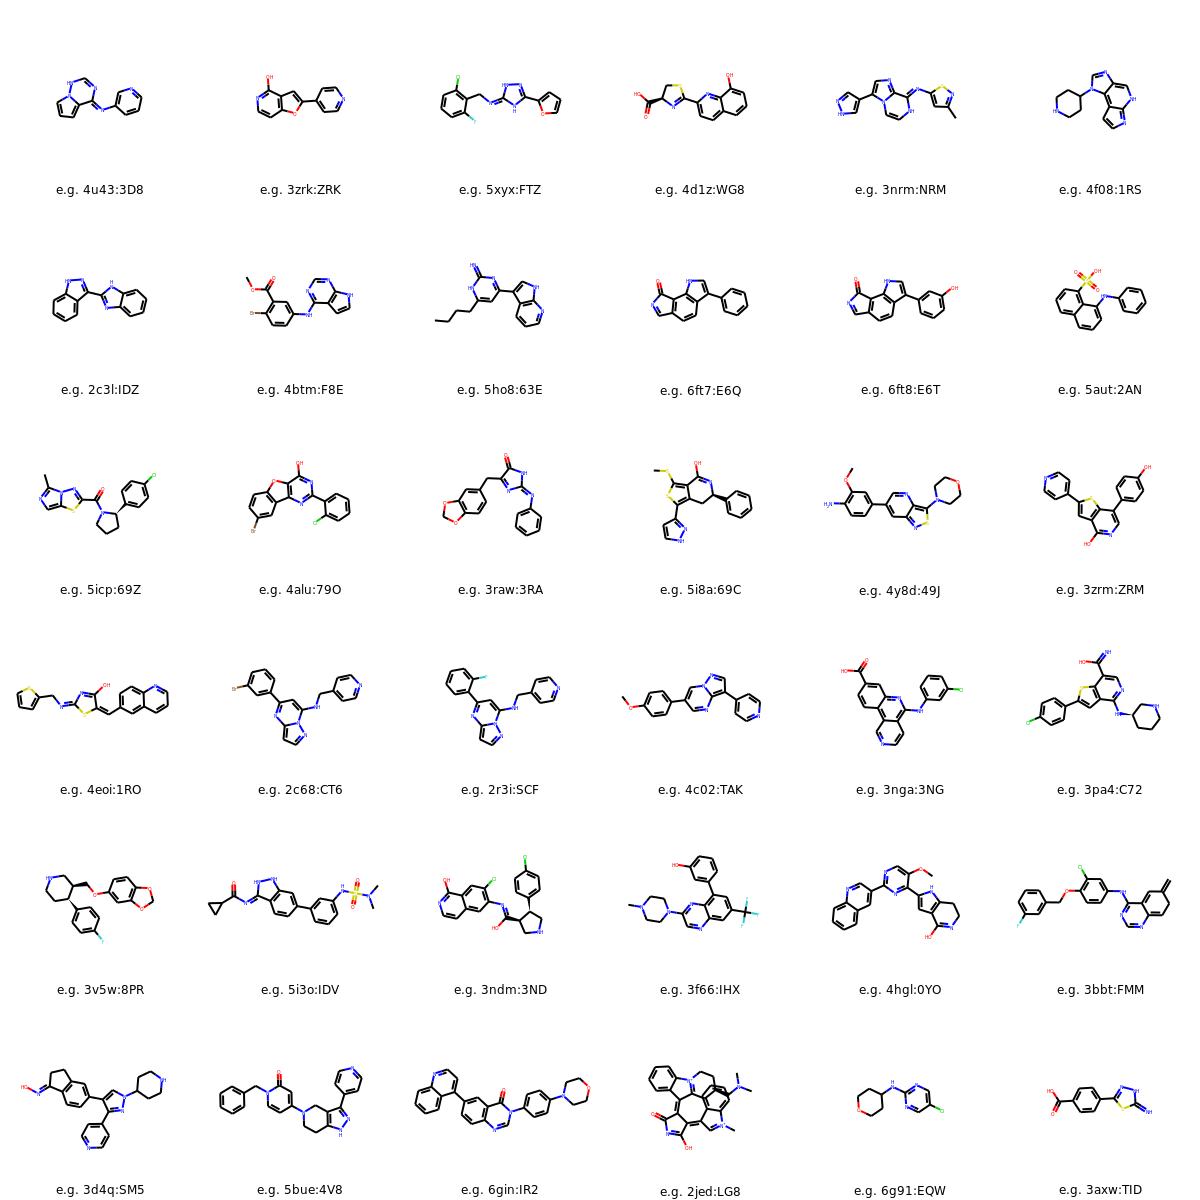

In [17]:
Draw.MolsToGridImage(
    mols=original_ligands_fully_covered_deduplicated.inchi.apply(Chem.MolFromInchi),
    legends=original_ligands_fully_covered_deduplicated.apply(lambda x: f'e.g. {x.complex_pdb}:{x.ligand_pdb}', axis=1).tolist(),
    molsPerRow=6,
    maxMols=100
)

In [18]:
original_ligands_fully_covered_deduplicated['inchi'].to_csv('../data/fragment_library_reduced/original_exact_theoretical.csv', index=None)

### Number of ligands fully or partially covered by reduced fragment library

In [19]:
print('Number of ligands fully or partially covered by reduced fragment library:')
original_ligands[original_ligands.is_covered == True].shape[0]

Number of ligands fully or partially covered by reduced fragment library:


1453

In [20]:
print('Number of ligands fully or partially covered by reduced fragment library (deduplicated based on InChIs):')
original_ligands[original_ligands.is_covered == True].groupby('inchi').first().shape[0]

Number of ligands fully or partially covered by reduced fragment library (deduplicated based on InChIs):


1216

In [21]:
print('Number of ligands fully or partially covered by reduced fragment library (deduplicated based on SMILES):')
original_ligands[original_ligands.is_covered == True].groupby('smiles').first().shape[0]

Number of ligands fully or partially covered by reduced fragment library (deduplicated based on SMILES):


1229